# Where Should You Retire? Spain vs. Belize
## A Comparison Between an Iberian Destination and a Caribbean Paradise

In [1]:
import requests
import sqlite3
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from shapely import wkt

In [2]:
#!ogr2ogr --version

Import Geospatial data into Sqlite database file using ogr2ogr

In [3]:
# !ogr2ogr -f SQLite -lco FORMAT=WKT madrid1.sqlite madrid-latest.osm.pbf

In [4]:
!ogr2ogr -f SQLite -lco FORMAT=WKT belize1.sqlite belize-latest.osm.pbf

0...10...20...30...40...50...60...70...80...90...100 - done.


Connect to database and test query

In [5]:
# CONNECT TO MADRID SQLITE3 DB

DATA = "./madrid1.sqlite"
con = sqlite3.connect(DATA)
cursor = con.cursor()

# Get all table names -- found in table "sqlite_master"
query = """
SELECT 
    name
FROM 
    sqlite_master
WHERE 
    type ='table' AND 
    name NOT LIKE 'sqlite_%';
    """

tables = cursor.execute(query)
tables.fetchall()

[('geometry_columns',),
 ('spatial_ref_sys',),
 ('points',),
 ('lines',),
 ('multilinestrings',),
 ('multipolygons',),
 ('other_relations',)]

In [6]:
# CONNECT TO BELIZE SQLITE3 DB

DATA_BZ = "./belize1.sqlite"
con_bz = sqlite3.connect(DATA_BZ)
cursor_bz = con_bz.cursor()

# Get all table names -- found in table "sqlite_master"
query_bz = """
SELECT 
    name
FROM 
    sqlite_master
WHERE 
    type ='table' AND 
    name NOT LIKE 'sqlite_%';
    """

tables_bz = cursor.execute(query)
tables_bz.fetchall()

[('geometry_columns',),
 ('spatial_ref_sys',),
 ('points',),
 ('lines',),
 ('multilinestrings',),
 ('multipolygons',),
 ('other_relations',)]

### Preview Tables 

Spatialite `geometry_types` have the following values (taken from https://www.gaia-gis.it/gaia-sins/BLOB-Geometry.html)

- 1 = POINT

- 2 = LINESTRING

- 3 = POLYGON

- 4 = MULTIPOINT

- 5 = MULTILINESTRING

- 6 = MULTIPOLYGON

- 7 = GEOMETRYCOLLECTION

The `geometry_columns` table contains useful metadata about our geometries and is created by SQLite, or to be specific, Spatialite — SQLite’s geoextension.

Our data has the `polygons` and `multipoints` tables missing. It turns out there are multipolygons in the `multipolygon` table that actually only contain one polygon. This seems to be how the OSM elements are matched to Spatialite types.

In [7]:
# Preview Geometry table
geometry_columns = pd.read_sql("SELECT * FROM geometry_columns;", con)
geometry_columns

,f_table_name,f_geometry_column,geometry_type,coord_dimension,srid,geometry_format
0,points,WKT_GEOMETRY,1,2,4326,WKT
1,lines,WKT_GEOMETRY,2,2,4326,WKT
2,multilinestrings,WKT_GEOMETRY,5,2,4326,WKT
3,multipolygons,WKT_GEOMETRY,6,2,4326,WKT
4,other_relations,WKT_GEOMETRY,7,2,4326,WKT


The `spatial_ref_sys` shows us which Spatial Reference System is being used; in our case 4326, a standard in web maps.
The Spatial Reference System describes the framework used to precisely measure locations on the surface of Earth as coordinates. 

See reference for more info:
https://en.wikipedia.org/wiki/Spatial_reference_system

In [8]:
# Preview Spatial Ref Sys table
spatial_ref_sys = pd.read_sql("SELECT * FROM spatial_ref_sys;", con)
spatial_ref_sys

,srid,auth_name,auth_srid,srtext
0,4326,EPSG,4326,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS..."


In [9]:
# Preview Points table
points = pd.read_sql("SELECT * FROM points;", con)
points.head()

,ogc_fid,WKT_GEOMETRY,osm_id,name,barrier,highway,ref,address,is_in,place,man_made,other_tags
0,1,POINT (-3.6844432 40.4212466),171946,None,None,traffic_signals,None,None,None,None,None,"""crossing""=>""traffic_signals"",""crossing_ref""=>..."
1,2,POINT (-3.6063476 40.4350328),20952908,None,None,crossing,None,None,None,None,None,"""crossing""=>""traffic_signals"""
2,3,POINT (-3.6064513 40.4351013),20952918,None,None,give_way,None,None,None,None,None,"""source:date""=>""2014"""
3,4,POINT (-3.6080503 40.4343659),20952921,None,None,crossing,None,None,None,None,None,None
4,5,POINT (-3.6051218 40.4295407),20952943,None,None,traffic_signals,None,None,None,None,None,"""traffic_signals""=>""signal"""


### Get All Geometries into One DF

In [10]:
# MADRID: get all geometries into one dataframe
madrid_df = pd.DataFrame()
for geom_type in ['lines', 'points', 'multilinestrings', 'multipolygons', 'other_relations']:
  df = pd.read_sql(f"SELECT *, '{geom_type}' AS table_name FROM {geom_type};", con)
  madrid_df = pd.concat([madrid_df, df], ignore_index=True)

In [11]:
#BELIZE: get all geometries into one dataframe

bz_df = pd.DataFrame()
for geom_type in ['lines', 'points', 'multilinestrings', 'multipolygons', 'other_relations']:
  df = pd.read_sql(f"SELECT *, '{geom_type}' AS table_name FROM {geom_type};", con_bz)
  bz_df = pd.concat([bz_df, df], ignore_index=True)

In [12]:
bz_df.head(2)

,ogc_fid,WKT_GEOMETRY,osm_id,name,highway,waterway,aerialway,barrier,man_made,railway,...,historic,land_area,landuse,leisure,military,natural,office,shop,sport,tourism
0,1,"LINESTRING (-89.1656843 16.8246982,-89.1630574...",11801171,Guatemala - Belize,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,"LINESTRING (-88.8844791 15.8637806,-88.8849226...",20949485,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Convert to GeoPandas DataFrames

In [13]:
# BELIZE: convert dataframe into geodataframe
bz_df['geom'] = gpd.GeoSeries.from_wkt(bz_df['WKT_GEOMETRY'])
gdf_bz = gpd.GeoDataFrame(bz_df, geometry='geom')

In [14]:
# MADRID: convert dataframe into geodataframe
madrid_df['geom'] = gpd.GeoSeries.from_wkt(madrid_df['WKT_GEOMETRY'])
gdf_md = gpd.GeoDataFrame(madrid_df, geometry='geom')


### Exploring our OSM Data Using GeoPandas

OSM data is organised using tags. We can check the Wiki for details on tag usage and what they mean.
https://wiki.openstreetmap.org/wiki/Tags

In [15]:
gdf_bz.shape

(276855, 37)

In [16]:
gdf_md.shape

(1451714, 37)

In [17]:
gdf_md.columns

Index(['ogc_fid', 'WKT_GEOMETRY', 'osm_id', 'name', 'highway', 'waterway',
       'aerialway', 'barrier', 'man_made', 'railway', 'z_order', 'other_tags',
       'table_name', 'ref', 'address', 'is_in', 'place', 'type', 'osm_way_id',
       'aeroway', 'amenity', 'admin_level', 'boundary', 'building', 'craft',
       'geological', 'historic', 'land_area', 'landuse', 'leisure', 'military',
       'natural', 'office', 'shop', 'sport', 'tourism', 'geom'],
      dtype='object')

In [18]:
gdf_bz.head(2)

,ogc_fid,WKT_GEOMETRY,osm_id,name,highway,waterway,aerialway,barrier,man_made,railway,...,land_area,landuse,leisure,military,natural,office,shop,sport,tourism,geom
0,1,"LINESTRING (-89.1656843 16.8246982,-89.1630574...",11801171,Guatemala - Belize,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-89.16568 16.82470, -89.16306 16.8..."
1,2,"LINESTRING (-88.8844791 15.8637806,-88.8849226...",20949485,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-88.88448 15.86378, -88.88492 15.8..."


In [19]:
gdf_md.head(2)

,ogc_fid,WKT_GEOMETRY,osm_id,name,highway,waterway,aerialway,barrier,man_made,railway,...,land_area,landuse,leisure,military,natural,office,shop,sport,tourism,geom
0,1,"LINESTRING (-3.7441403 40.3618306,-3.7437236 4...",3996189,M-40,motorway,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-3.74414 40.36183, -3.74372 40.361..."
1,2,"LINESTRING (-3.5969146 40.4305754,-3.59703 40....",3996190,Avenida de Arcentales,primary,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-3.59691 40.43058, -3.59703 40.430..."


In [20]:
some = {"waterway":['river', 'stream'], "highway":['road','street']}.keys()

### Visualize Country boundaries

In [69]:
def plot_features(title, col, features, dfs=[gdf_md, gdf_bz], places=['Madrid', 'Belize']):
    """
    A function that overlays inputted features on the country map bounds.
    
    dfs: list,
    col: str,
    features: list,
    title: str,
    return: subsetted dataframe
    
    """
    fig, axs = plt.subplots(2,1, figsize=(30,30))
    
    for ax, df, place in zip(axs, dfs, places):
        # plot boundaries
        boundaries = df[ df['boundary'] == 'administrative']
        boundaries.plot(column='name', cmap="Greys", alpha=0.25, ax=ax)
        ax.set_xlabel(place.capitalize(), fontsize=20)

        # overlay feature
        condition = df[col].isin(features)
        df[condition].plot(ax=ax, column=col, cmap='viridis', legend=True)
        
        
        #ax.legend(features)
        fig.suptitle(title, fontsize=40, y=1)
        plt.tight_layout()
        

## Which country is more pedestrian friendly?

From the available tags, I have selected the options: `bus_stop`, `cycleway`, `pedestrian` and `footway` as proxies for good public transportation and accessibility, though this may not be an exhaustive list.

- `bus_stop` - A small bus stop.
- `cycleway` - For designated cycleways.
- `pedestrian` - For roads used mainly/exclusively for pedestrians in shopping and some residential areas which may allow access by motorised vehicles only for very limited periods of the day.
- `footway` - For designated footpaths; i.e., mainly/exclusively for pedestrians. This includes walking tracks and gravel paths

In [70]:
pedestrian = ['bus_stop','cycleway', 'footway', 'pedestrian']

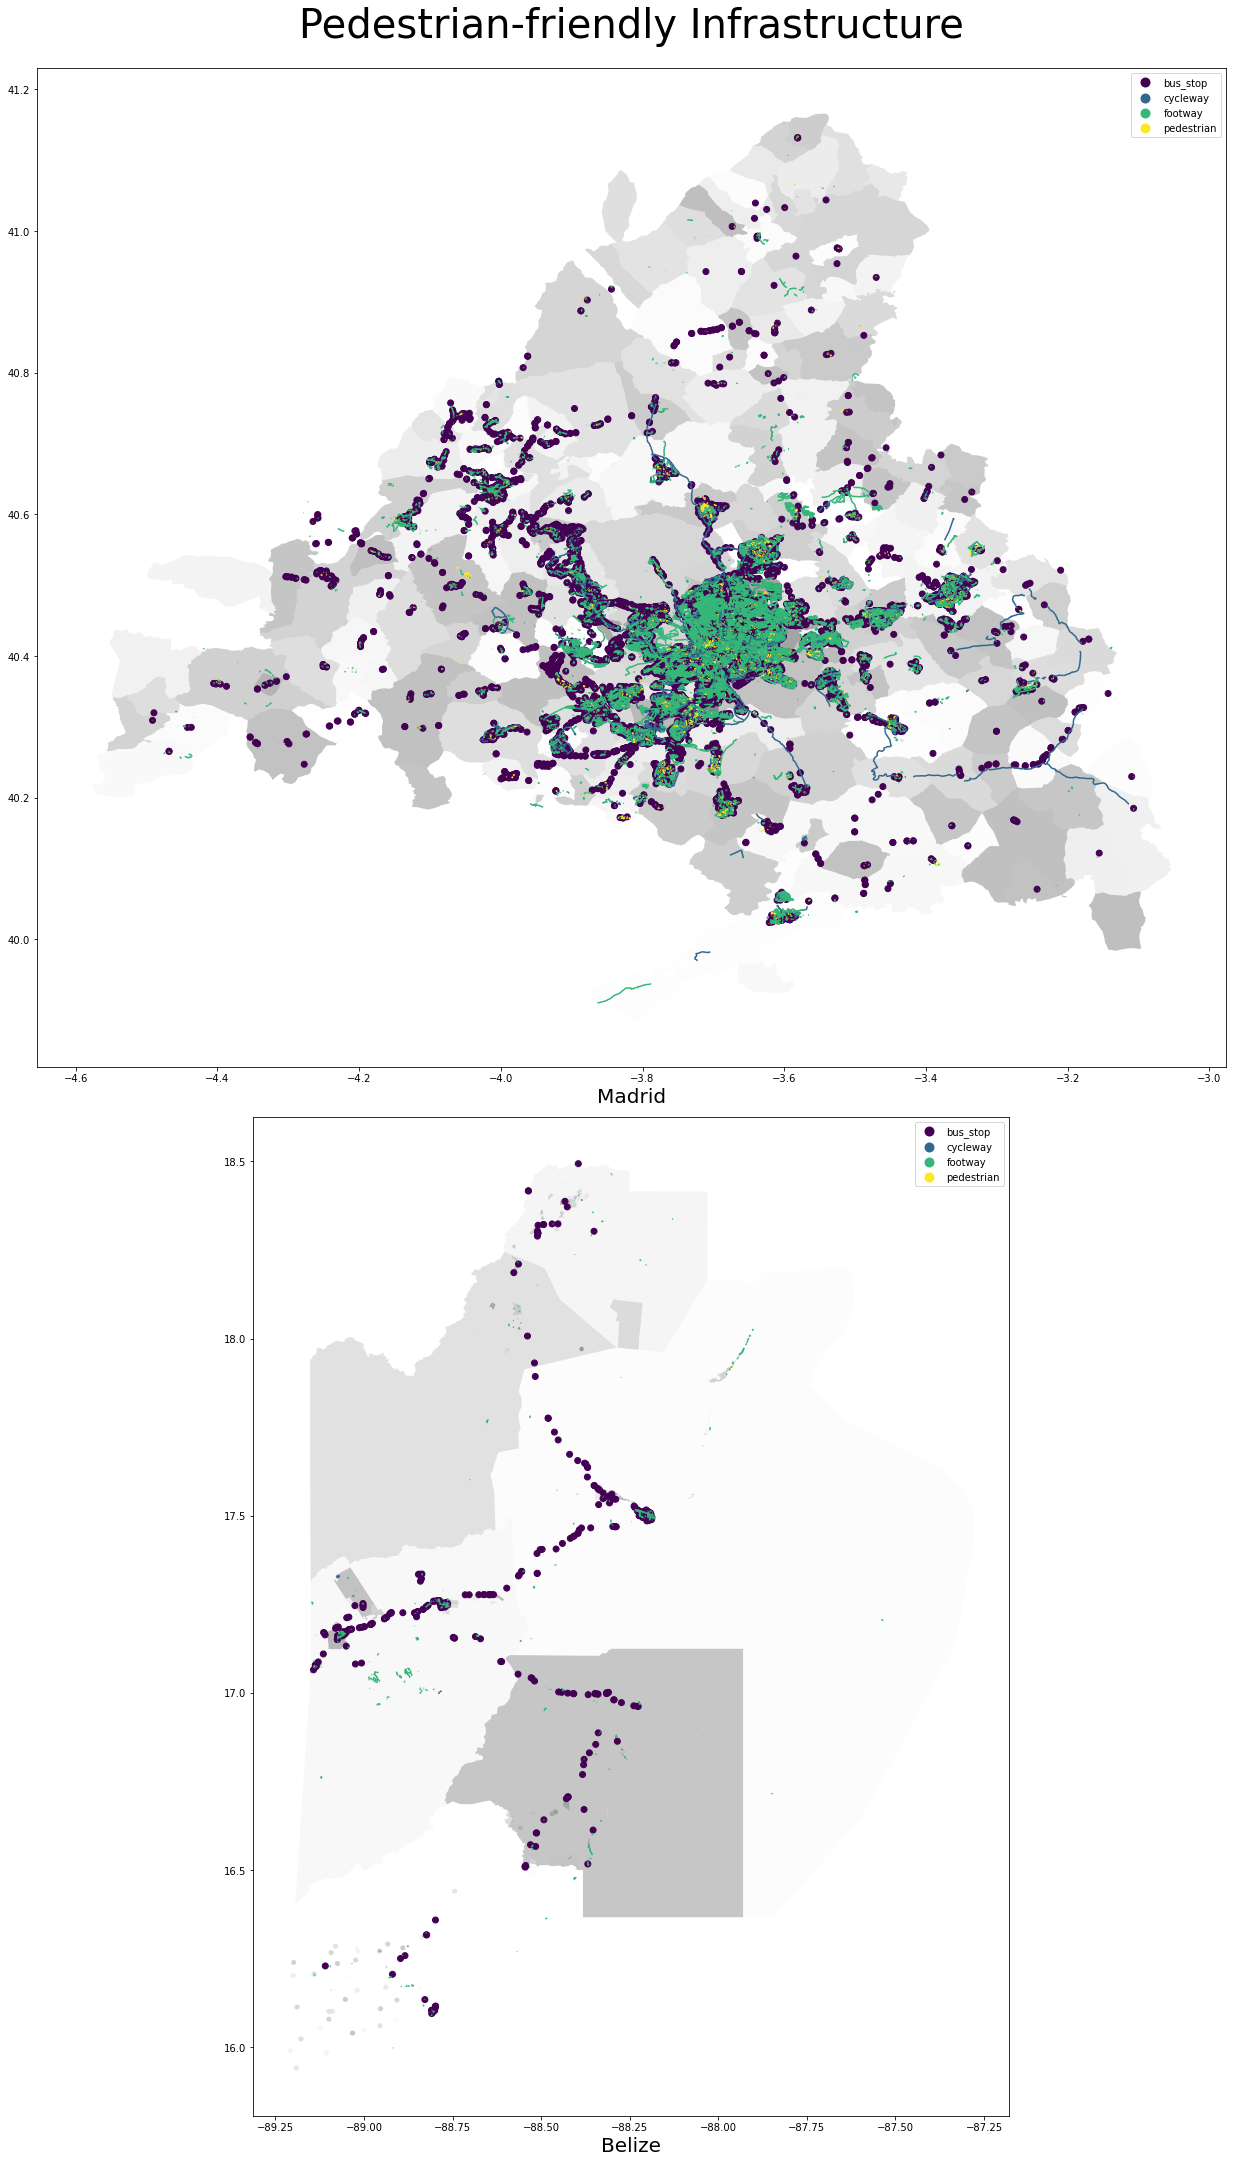

In [71]:
# Plot the public transportation infrastructure for both countries
ped_friendly = plot_features(title="Pedestrian-friendly Infrastructure", col='highway', features=pedestrian)
ped_friendly

### Which country is more family-friendly?

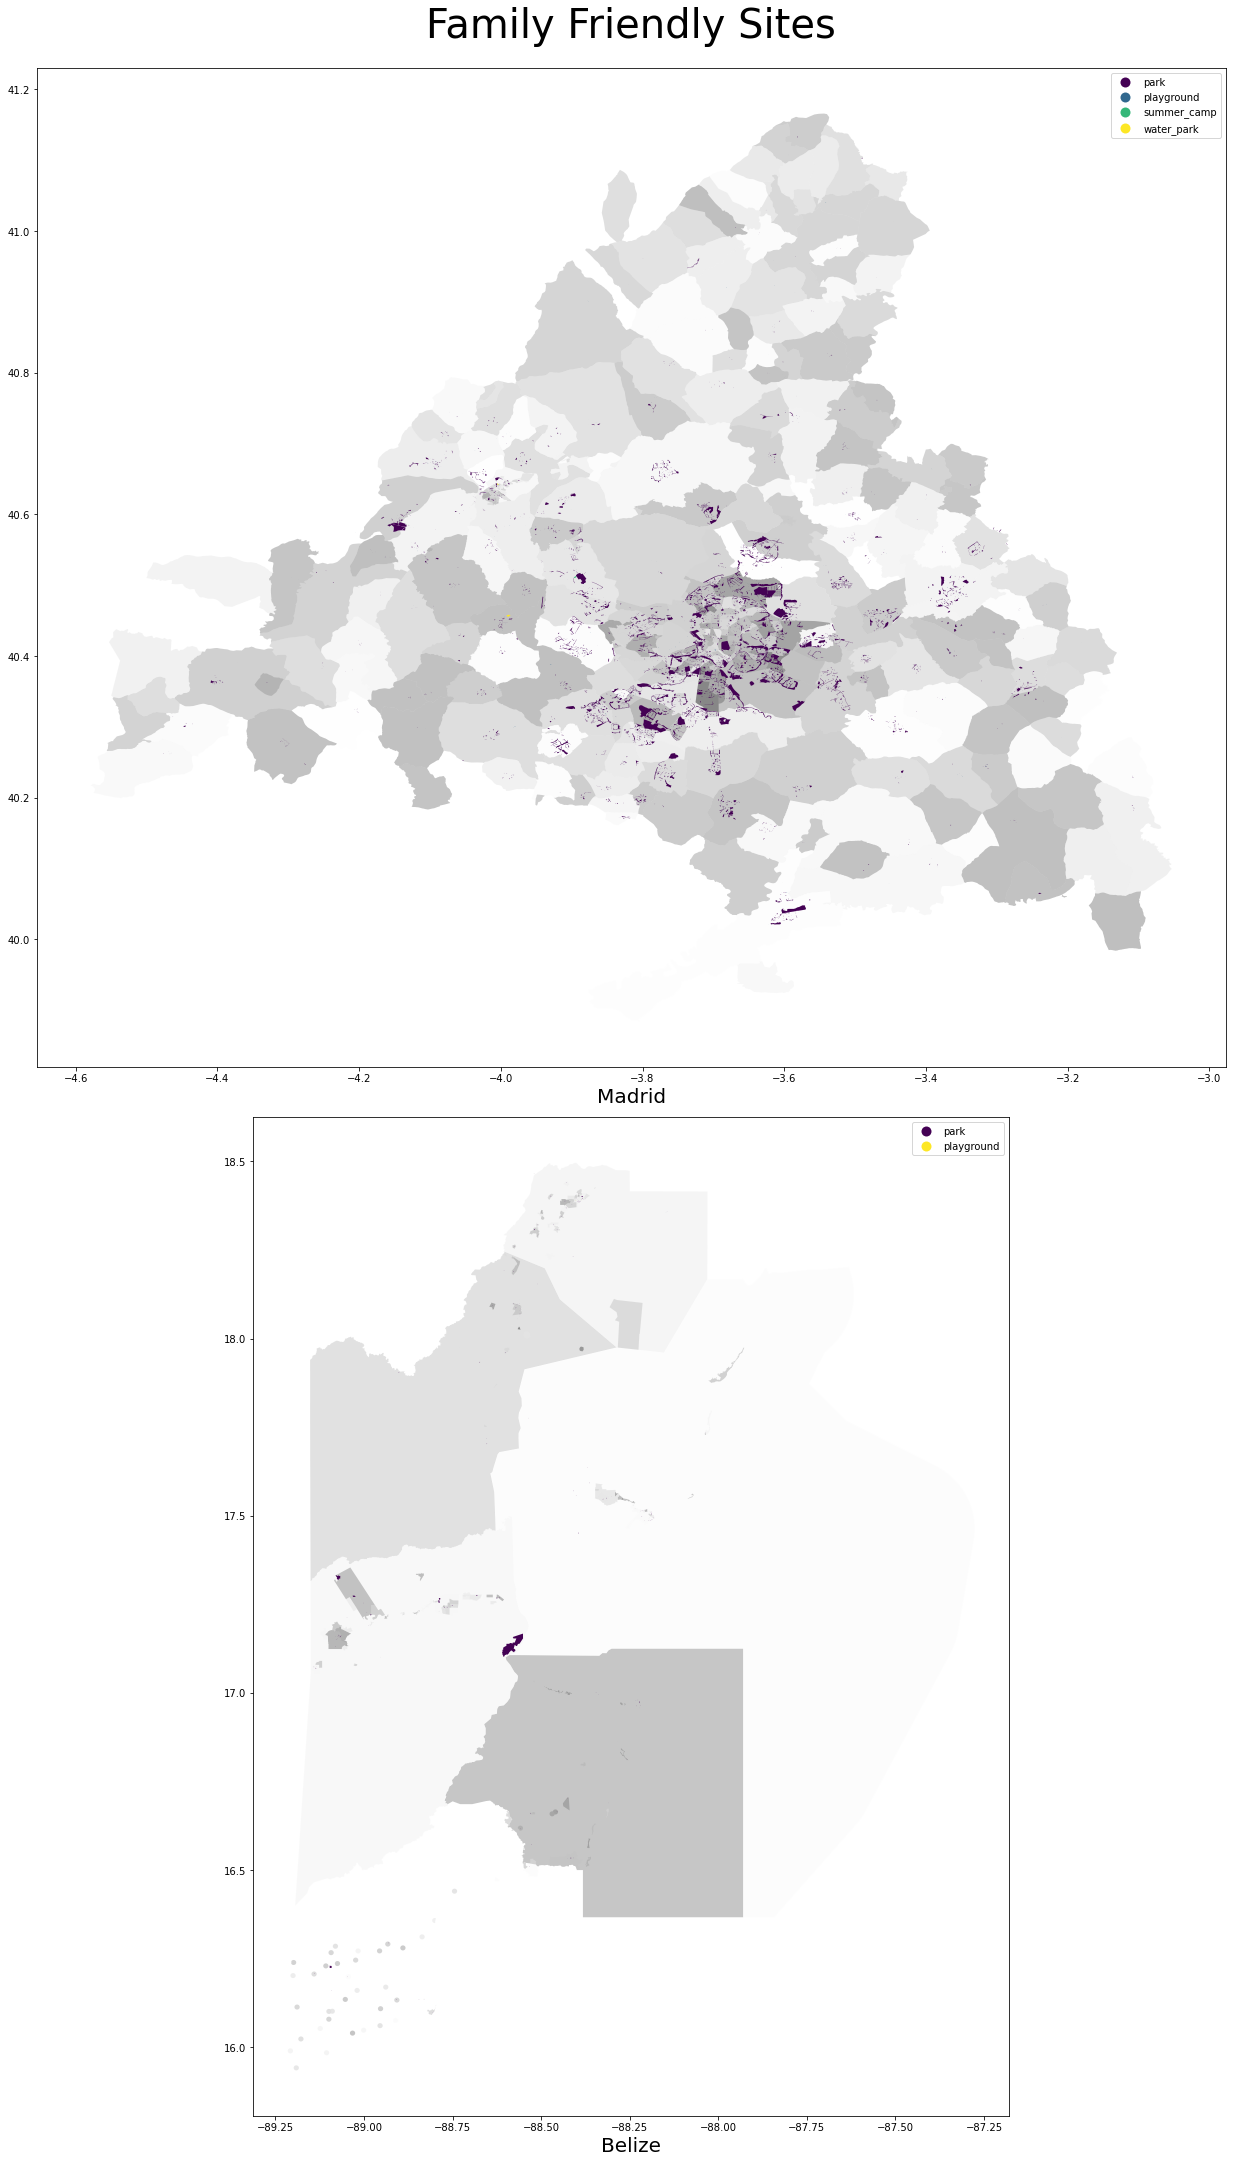

In [140]:
leisures = ['playground', 'park', 'summer_camp', 'water_park', 'trampoline_park']
plot_features(title='Family Friendly Sites', col='leisure', features=leisures)

### Which country might have more natural beauty?

- `wood` - Tree-covered area (a 'forest' or 'wood').
- `reef` - A feature (rock, sandbar, coral, etc) lying beneath the surface of the water.
- `water` - Any body of water, from natural such as a lake or pond to artificial like moat or canal.

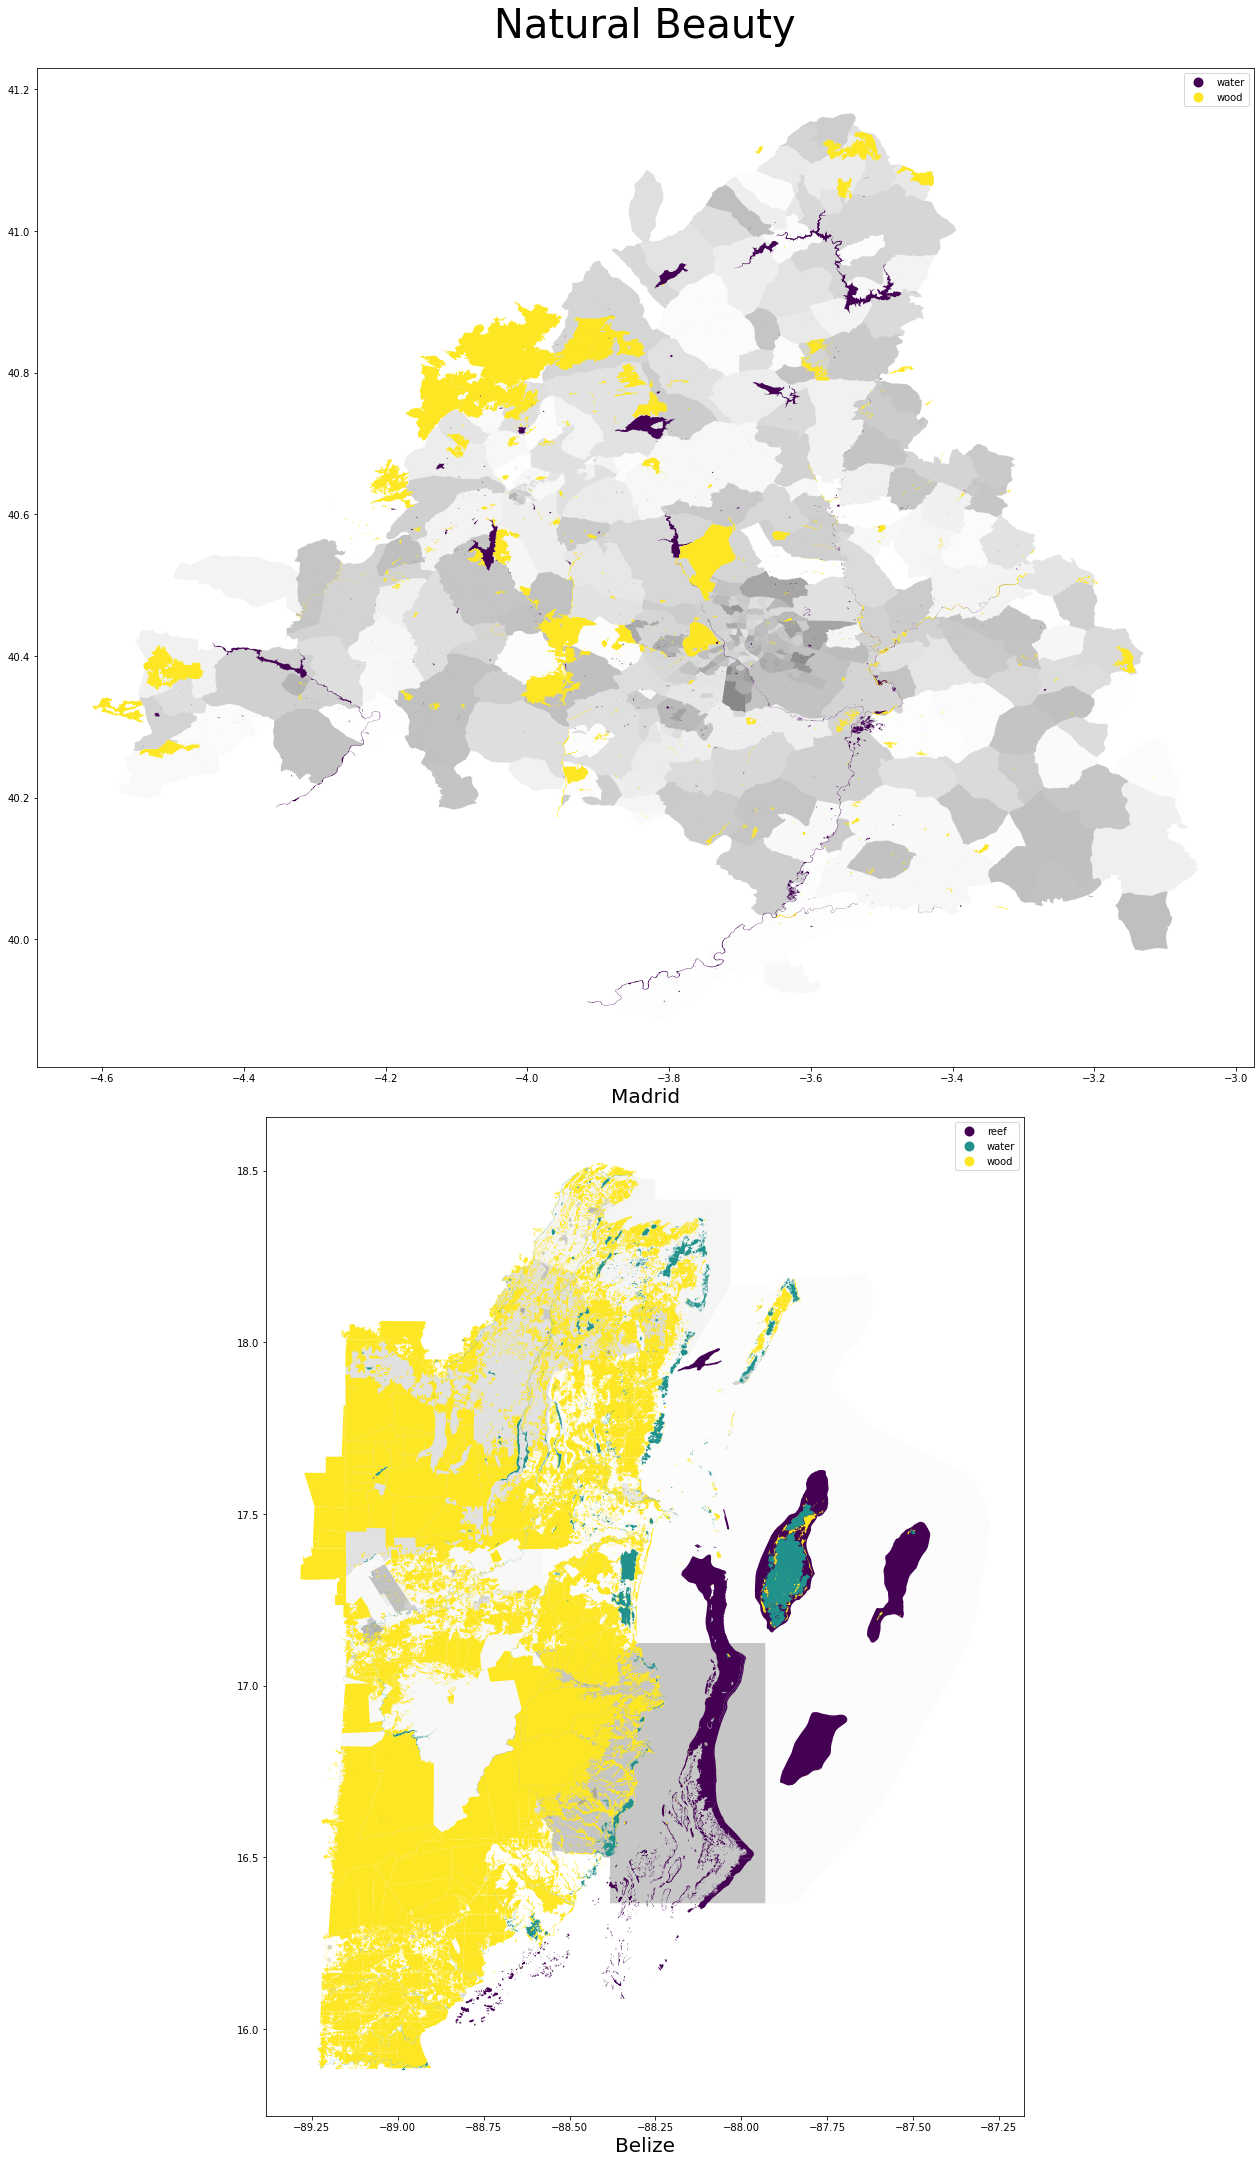

In [141]:
conservation = ['wood', 'reef', 'water']
plot_features(title='Natural Beauty', col='natural', features=conservation)

### Which country has a strong emphasis on Conservation?

Climate change-friendly and conservation-friendly countries are points of interest for me. The `'nature_reserve'` tag under the `leisure` column allows us to visualize the areas of conservation in the places of interest.

- `nature_reserve` - Protected area of importance for wildlife, flora, fauna or features of geological or other special interest.

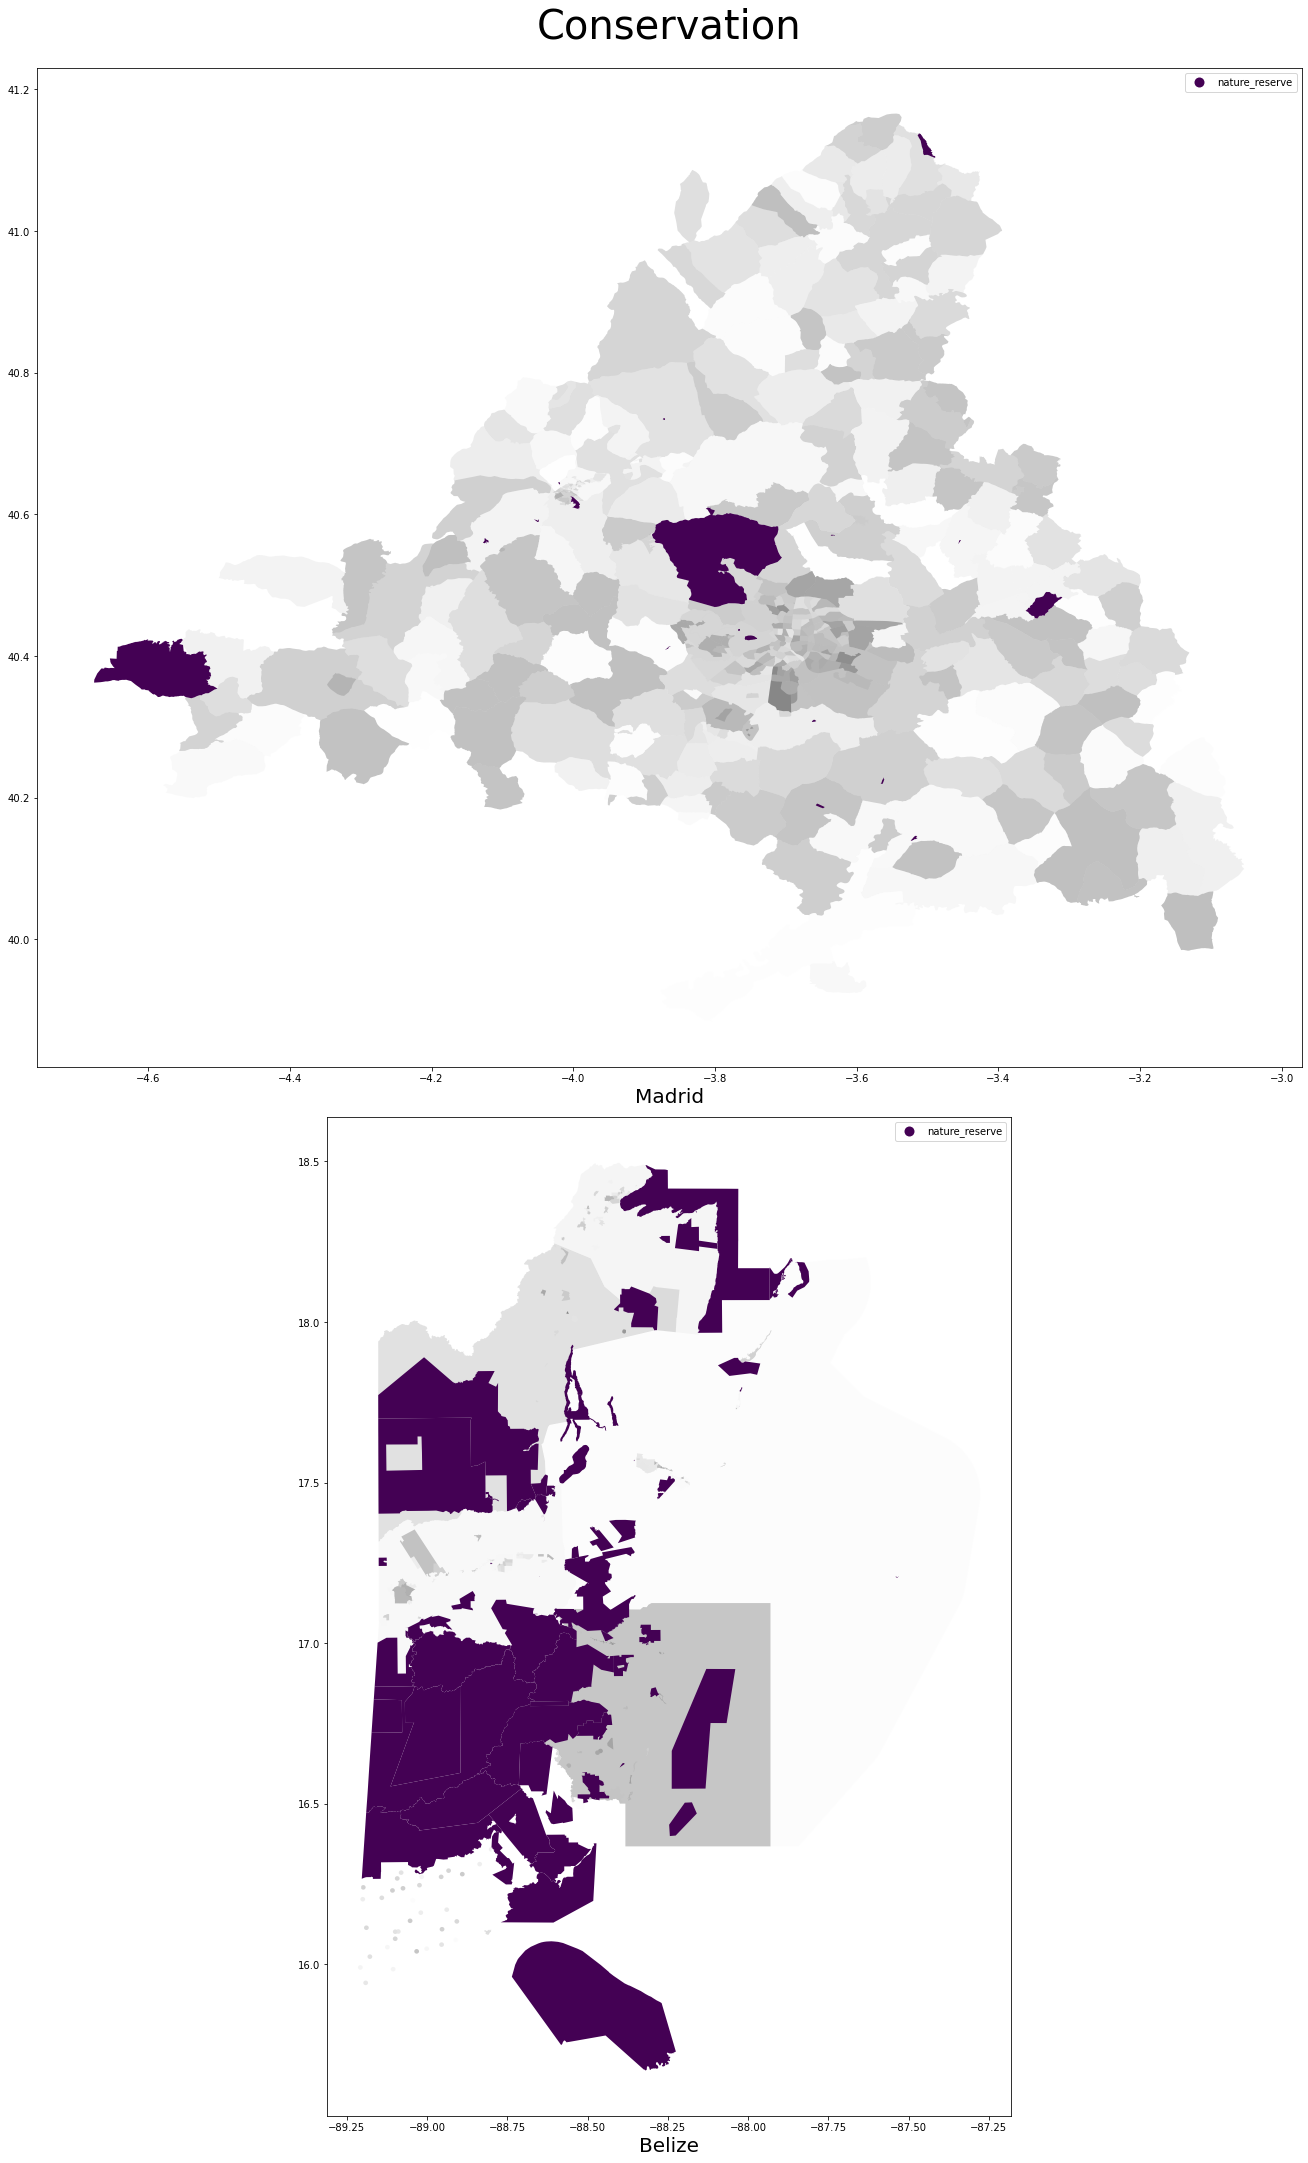

In [76]:
plot_features(title="Conservation", col="leisure", features=['nature_reserve'])

### Which country might have more waterways for recreational activities?

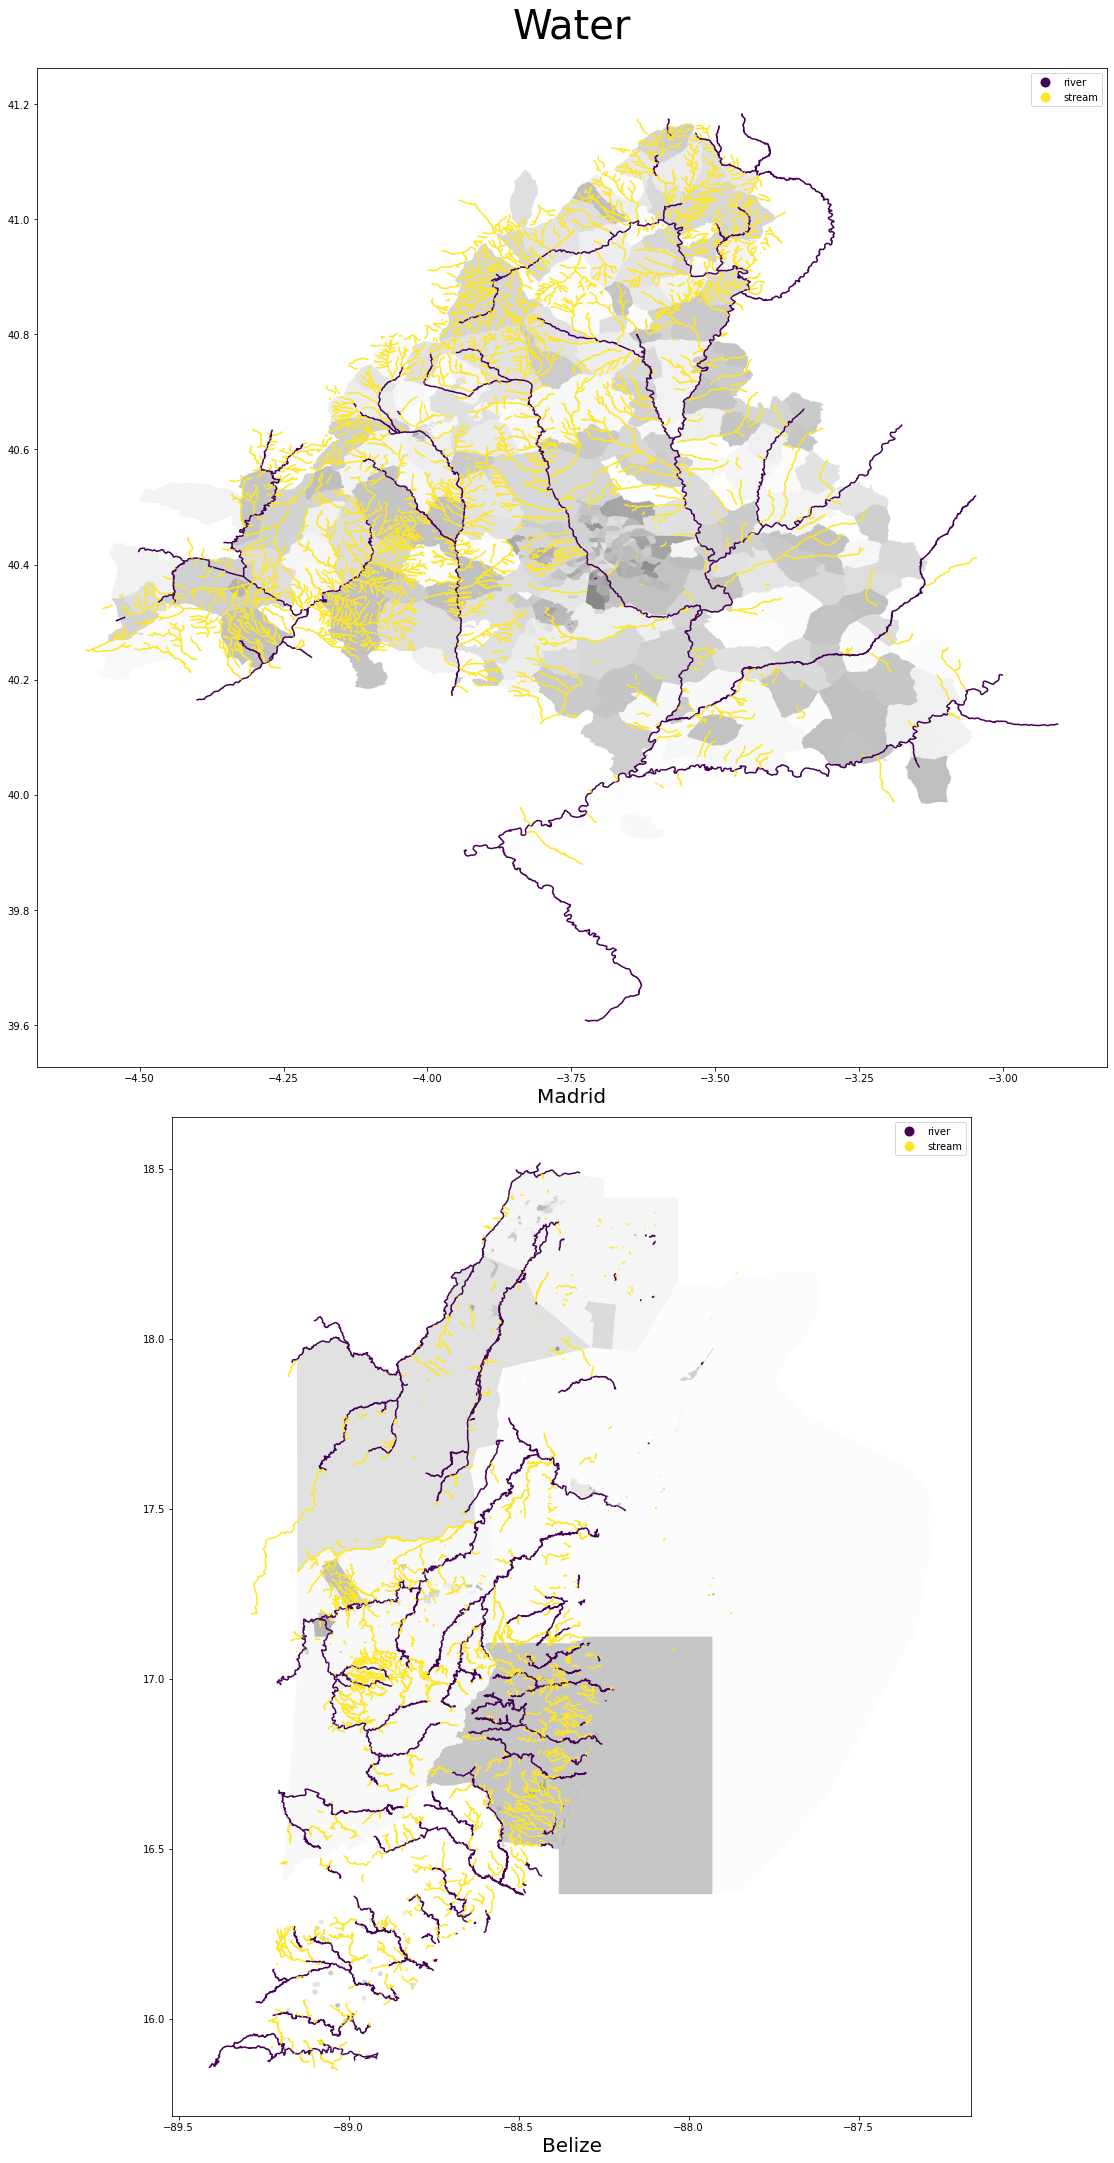

In [80]:
water = ['river', 'stream']
plot_features(title='Water', col='waterway', features=water)